# Проект. Исследование стартапов

## Введение

**Цель проекта**: исследование закономерностей финансирования стартапов.

**Задачи**:
1. ознакомиться и предобработать данные;
2. проанализировать и сгруппировать данные по значимым признакам;
3. обработать выбросы в данных и анализ финансирования;
4. проанализировать динамику финансирования.

## Шаг 1. Знакомство с данными: загрузка и предобработка

Датасет получен из базы данных стартапов.

### 1.1. Вывод общей информации

In [1]:
# Импортируем библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Уберем предупреждения
import warnings
warnings.filterwarnings('ignore')

Загрузка данных по проекту.

In [2]:
df = pd.read_csv("sample_1.zip", sep=';', low_memory=False)

In [3]:
df_ad = pd.read_csv("sample_2.csv")

Вывод информации, которая необходима для принятия решений о предобработке.

In [4]:
# Используем функцию для обзора данных:
def review(df, df_name):
    print(f'{"-"*50}')
    print(f'ОБЗОР ДАННЫХ: {df_name}')
    print(f'{"-"*50}')
    print(f'\nКОЛИЧЕСТВО СТРОК: {len(df)}')
    print('\nПЕРВЫЕ 5 СТРОК:')
    print(df.head())
    print('\nИНФОРМАЦИЯ О ДАННЫХ:')
    print(df.info())
    print('\nКОЛИЧЕСТВО ПРОПУСКОВ:')
    missing_count = df.isna().sum()
    if missing_count.sum() != 0:
        print(missing_count[missing_count>0])
    else:
        print('Пропусков нет')
    print('\nПРОЦЕНТ ПРОПУСКОВ:')
    missing_percent = round((df.isna().mean() * 100), 2)
    if missing_percent.sum() != 0:
        print(missing_percent[missing_percent > 0])
    else:
        print('0%')
    print('\nРАСПРЕДЕЛЕНИЕ ДАННЫХ:')
    print(df.describe())
    print('\nУНИКАЛЬНЫЕ ЗНАЧЕНИЯ КАТЕГОРИАЛЬНЫХ СТОЛБЦОВ:')
    has_cat_cols = False
    for column in list(df.columns):
        if (df[column].dtypes == 'object' or df[column].dtypes == 'category') and df[column].nunique() <= 15:
            has_cat_cols = True
            print(f'{column}:')
            print(df[column].unique())
    if not has_cat_cols:
        print('Категориальные столбцы не найдены или все имеют более 15 уникальных значений')
    print('\nКОЛИЧЕСТВО ЯВНЫХ ДУБЛИКАТОВ:')
    duplicates = df.duplicated().sum()
    print(duplicates if duplicates != 0 else 0)


In [5]:
# Вызовем функцию
dataframes = [df, df_ad]
names = ["df", "df_ad"]

for i, current_df in enumerate(dataframes):
    review(current_df, names[i])

--------------------------------------------------
ОБЗОР ДАННЫХ: df
--------------------------------------------------

КОЛИЧЕСТВО СТРОК: 54294

ПЕРВЫЕ 5 СТРОК:
                              name           homepage_url  \
0               Harvard University     http://harvard.edu   
1      University of New Brunswick      http://www.unb.ca   
2                           DuPont  http://www.dupont.com   
3           University of Michigan  http://www.umich.edu/   
4  Case Western Reserve University    http://www.case.edu   

                                       category_list              market   \
0                                        |Education|           Education    
1                                                NaN                  NaN   
2  |Business Services|Agriculture|Automotive|Inve...   Business Services    
3                                        |Education|           Education    
4                                        |Education|           Education    

   fundin

In [6]:
# Дополнительно сохраним изначальное количество строк датасета. Нужно будет далее в проекте.
initial_row_count = df.shape[0]
initial_row_count

54294

### Промежуточные выводы
**Основной датафрейм**:
1. В датафрейме **54** тыс. строк.
2. Во **всех столбцах** присутствуют пропуски.
3. В данных есть **явные дубликаты**, причем их количество совпадает с количеством пропусков в некоторых столбцах. Вероятно, **они связаны**.
4. Минимальный год основания - **1636**, максимальный - **2014**.
5. Все числовые данные с типом данных `float`, а столбцы с датой с типом `object`.
6. Названия столбцов отражают их содержание и написаны в snake case. Однако у некоторых столбцов присутствуют лишние пробелы.

**Дополнительный датафрейм**:
1. В датафрейме **15** строк.
2. Пропусков **нет**.
3. Явных дубликатов **нет**.
4. Минимальный год в данных - **2000**, максимальный - **2014**.
5. Все столбцы кроме столбца `year` в типе данных `float`, `year` - в `int`.
6. Названия столбцов отражают их содержание и написаны в snake case.


### 1.2. Предобработка данных

In [7]:
# Уберем лишние проблемы с помощью метода `strip`
df.columns = df.columns.str.strip()

In [8]:
# Уберем запятые из столбца
df['funding_total_usd'] = df['funding_total_usd'].astype('str').str.replace(',', '')
# Преобразуем столбец в тип данных `float`
df['funding_total_usd'] = pd.to_numeric(df['funding_total_usd'], errors='coerce', downcast='float')
df['funding_total_usd'].dtype

dtype('float64')

In [9]:
# Преобразуем столбцы `founded_at`, `first_funding_at`, `mid_funding_at`, `last_funding_at` в `datetime`
for column in ['founded_at','first_funding_at','mid_funding_at','last_funding_at']:
    df[column] = pd.to_datetime(df[column], errors='coerce')
    print(df[column].dtype)

# Преобразуем столбец `founded_month` в `period`
df['founded_month'] = pd.to_datetime(df['founded_month'], errors='coerce', format='%Y-%m').dt.to_period('M')
print(df['founded_month'].dtype)

# Заменим кварталы в столбце `founded_quarter` на даты
df['founded_quarter'] = df['founded_quarter'].replace({'Q1': '01-01', 'Q2': '04-01', 'Q3': '07-01', 'Q4': '10-01'})
# Преобразуем столбец в `period`
df['founded_quarter'] = pd.to_datetime(df['founded_quarter'], errors='coerce').dt.to_period('Q')
print(df['founded_quarter'].dtype)


datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]
period[M]
period[Q-DEC]


In [10]:
# Делаем столбец `year` индексом
df_ad.set_index('year', inplace=True)
df_ad.head()

,seed,venture,equity_crowdfunding,undisclosed,convertible_note,debt_financing,angel,grant,private_equity,post_ipo_equity,post_ipo_debt,secondary_market,product_crowdfunding
year,,,,,,,,,,,,,
2000,16.70,55.40,0.0,78.21,0.00,8.66,6.43,0.0,0.00,0.94,0.0,0.20,0.0
2001,2.88,23.49,0.0,21.50,0.01,4.49,1.18,0.0,0.00,0.46,0.0,0.46,0.0
2002,6.59,209.42,0.0,25.77,0.02,3.42,3.41,0.0,1.51,0.34,0.0,0.06,0.0
2003,7.74,233.86,0.0,9.40,0.01,1.09,3.41,0.0,1.62,2.11,0.0,0.08,0.0
2004,9.93,555.90,0.0,33.19,0.01,13.55,9.18,0.0,2.19,3.38,0.0,0.55,0.0


In [11]:
# Нормализуем часть текстовых данных (нижний регистр, убраны пробелы и специальные символы)
for column in ['name','market','status', 'country_code', 'region', 'city', 'category_list']:
    df[column]=df[column].str.lower()
    df[column] = df[column].str.replace(' ', '')
    df[column] = df[column].str.replace(r'[^\w\s|]', '', regex=True)
# Поставим заглушку в столбец `market`
    df['market'] = df['market'].fillna('unknown')

In [12]:
# Удалим строки, которые не содержат информации о финансировании в столбце `funding_total_usd`
df.dropna(subset=['funding_total_usd'], inplace=True)
# Уберем полные дубликаты из данных
df.drop_duplicates(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40907 entries, 0 to 49437
Data columns (total 40 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   name                  40906 non-null  object        
 1   homepage_url          38593 non-null  object        
 2   category_list         38404 non-null  object        
 3   market                40907 non-null  object        
 4   funding_total_usd     40907 non-null  float64       
 5   status                39802 non-null  object        
 6   country_code          37088 non-null  object        
 7   state_code            25619 non-null  object        
 8   region                37088 non-null  object        
 9   city                  36402 non-null  object        
 10  funding_rounds        40907 non-null  float64       
 11  participants          27331 non-null  float64       
 12  founded_at            32200 non-null  datetime64[ns]
 13  founded_month        

Заполним пропуски в значениях `mid_funding_at` на основании значений в столбцах `first_funding_at` и `last_funding_at`. В качестве нового значения вместо пропусков возьмем приблизительно середину интервала между этими двумя датами.

In [13]:
def fill_func(row):
    if pd.isna(row['mid_funding_at']):
        # Вычисляем среднее арифметическое между двумя датами
        delta = (row['last_funding_at'] - row['first_funding_at']) / 2
        # Добавляем половину разницы к первой дате
        return row['first_funding_at'] + delta
    return row['mid_funding_at']

df['mid_funding_at'] = df.apply(fill_func, axis=1)

In [14]:
# Проверим сколько пропусков осталось
print(f"Количество пропусков в столбце mid_funding_at:{df['mid_funding_at'].isna().sum()}")
print(f"Доля пропусков в столбце mid_funding_at:{df['mid_funding_at'].isna().sum()/df['mid_funding_at'].shape[0]*100:.2f}%")

Количество пропусков в столбце mid_funding_at:1
Доля пропусков в столбце mid_funding_at:0.00%


In [15]:
# Оценим полноту датафрейма
for column in list(df.columns):
    print(f"Количество пропусков в столбце {column}:{df[column].isna().sum()}")
    print(f"Доля пропусков в столбце {column}:{df[column].isna().sum()/df[column].shape[0]*100:.2f}%\n")

Количество пропусков в столбце name:1
Доля пропусков в столбце name:0.00%

Количество пропусков в столбце homepage_url:2314
Доля пропусков в столбце homepage_url:5.66%

Количество пропусков в столбце category_list:2503
Доля пропусков в столбце category_list:6.12%

Количество пропусков в столбце market:0
Доля пропусков в столбце market:0.00%

Количество пропусков в столбце funding_total_usd:0
Доля пропусков в столбце funding_total_usd:0.00%

Количество пропусков в столбце status:1105
Доля пропусков в столбце status:2.70%

Количество пропусков в столбце country_code:3819
Доля пропусков в столбце country_code:9.34%

Количество пропусков в столбце state_code:15288
Доля пропусков в столбце state_code:37.37%

Количество пропусков в столбце region:3819
Доля пропусков в столбце region:9.34%

Количество пропусков в столбце city:4505
Доля пропусков в столбце city:11.01%

Количество пропусков в столбце funding_rounds:0
Доля пропусков в столбце funding_rounds:0.00%

Количество пропусков в столбце 

Можно заметить, что в столбцах `name` и `..._funding_at` остались пропуски, но их объем ничтожен в рамках датафрейма. Их проще всего удалить.

In [16]:
# Удалим строки с пропусками в столбцах
df.dropna(subset=['name', 'first_funding_at', 'mid_funding_at', 'last_funding_at'], inplace=True)

In [17]:
# Проверим дубликаты столбца 'name'
df[df['name'].duplicated(keep=False)].sort_values(by = 'name', ascending = False)

,name,homepage_url,category_list,market,funding_total_usd,status,country_code,state_code,region,city,...,secondary_market,product_crowdfunding,round_A,round_B,round_C,round_D,round_E,round_F,round_G,round_H
26220,zoom,http://zoom.us,|collaboration|enterprisesoftware|,collaboration,15500000.0,operating,usa,CA,sfbayarea,santaclara,...,0.0,0.0,6000000.0,6500000.0,0.0,0.0,0.0,0.0,0.0,0.0
46712,zoom,http://www.zoomcar.in,|consumers|,consumers,1600000.0,operating,ind,NaN,bangalore,bangalore,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27994,yoquevos,http://yoquevos.com,|fashion|,fashion,25000.0,operating,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15977,yoquevos,http://www.yoquevos.com,|curatedweb|,curatedweb,25000.0,operating,arg,NaN,buenosaires,buenosaires,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3322,x1,http://www.xplusone.com/,|enterprisesoftware|,enterprisesoftware,45000000.0,operating,usa,NY,newyorkcity,newyork,...,0.0,0.0,16000000.0,10000000.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10350,adometrybygoogle,NaN,|advertising|analytics|displays|software|,software,450000.0,acquired,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29328,adhoclabs,http://adhoclabs.co,|mobile|,mobile,2000000.0,operating,usa,CA,losangeles,losangeles,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31914,adhoclabs,http://burnerapp.com,|mobile|,mobile,2000000.0,operating,usa,CA,losangeles,losangeles,...,0.0,0.0,2000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25663,5minutes,http://5minutes.to,|art|photography|socialmedia|curatedweb|,socialmedia,15873.0,operating,gbr,NaN,london,london,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Также в столбце `name` присутствуют **дубликаты**, наличие которых маловероятно по логике организации данных, но возможно, тем более, с учетом нормализации. Их малое число косвенно подтверждает, что это скорее исключение, чем правило.

In [18]:
# Уберем дубликаты по столбцам столбце 'name', 'homepage_url', 'market', 'country_code', 'founded_at'
df.drop_duplicates(subset=['name', 'homepage_url', 'market', 'country_code', 'founded_at'], inplace=True)

In [19]:
# Проверим дубликаты столбца 'name' повторно
df[df['name'].duplicated(keep=False)].sort_values(by = 'name', ascending = False)

,name,homepage_url,category_list,market,funding_total_usd,status,country_code,state_code,region,city,...,secondary_market,product_crowdfunding,round_A,round_B,round_C,round_D,round_E,round_F,round_G,round_H
46712,zoom,http://www.zoomcar.in,|consumers|,consumers,1600000.0,operating,ind,NaN,bangalore,bangalore,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26220,zoom,http://zoom.us,|collaboration|enterprisesoftware|,collaboration,15500000.0,operating,usa,CA,sfbayarea,santaclara,...,0.0,0.0,6000000.0,6500000.0,0.0,0.0,0.0,0.0,0.0,0.0
27994,yoquevos,http://yoquevos.com,|fashion|,fashion,25000.0,operating,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15977,yoquevos,http://www.yoquevos.com,|curatedweb|,curatedweb,25000.0,operating,arg,NaN,buenosaires,buenosaires,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3322,x1,http://www.xplusone.com/,|enterprisesoftware|,enterprisesoftware,45000000.0,operating,usa,NY,newyorkcity,newyork,...,0.0,0.0,16000000.0,10000000.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8545,adometrybygoogle,http://www.adometry.com,|displays|analytics|software|advertising|,software,29125000.0,acquired,usa,TX,austin,austin,...,0.0,0.0,5000000.0,10025000.0,6000000.0,8100000.0,0.0,0.0,0.0,0.0
31914,adhoclabs,http://burnerapp.com,|mobile|,mobile,2000000.0,operating,usa,CA,losangeles,losangeles,...,0.0,0.0,2000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29328,adhoclabs,http://adhoclabs.co,|mobile|,mobile,2000000.0,operating,usa,CA,losangeles,losangeles,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41693,5minutes,NaN,|games|,games,3500000.0,operating,chn,NaN,shanghai,shanghai,...,0.0,0.0,3500000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Большая часть дубликатов **осталась**. С учетом дополнительной обработки, проведенной выше, можно исходить из того, что фактически это не дубликаты, а, все же, разные компании. Даже если обработка и оставила какие-то дубликаты, то их количество **незначительно** в рамках датафрейма и не приведет к серьезному искажению результатов анализа. Чтобы технически убрать дубликаты, сделаем для них уникальные названия, чтобы упростить дальнейший анализ.

In [20]:
# Добавляем суффикс ко всем строкам
df['name'] = df['name'] + '_' + df.groupby('name').cumcount().astype(str)

# Убираем '_0' у уникальных имён
df['name'] = df['name'].str.replace(r'_0$', '', regex=True)

# Проверяем, что дубликатов по 'name' больше нет
print(f"Количество дубликатов по 'name': {df['name'].duplicated().sum()}")


Количество дубликатов по 'name': 0


In [21]:
# Оценим полноту датафрейма повторно
for column in list(df.columns):
    print(f"Количество пропусков в столбце {column}:{df[column].isna().sum()}")
    print(f"Доля пропусков в столбце {column}:{df[column].isna().sum()/df[column].shape[0]*100:.2f}%\n")

Количество пропусков в столбце name:0
Доля пропусков в столбце name:0.00%

Количество пропусков в столбце homepage_url:2314
Доля пропусков в столбце homepage_url:5.66%

Количество пропусков в столбце category_list:2503
Доля пропусков в столбце category_list:6.12%

Количество пропусков в столбце market:0
Доля пропусков в столбце market:0.00%

Количество пропусков в столбце funding_total_usd:0
Доля пропусков в столбце funding_total_usd:0.00%

Количество пропусков в столбце status:1105
Доля пропусков в столбце status:2.70%

Количество пропусков в столбце country_code:3818
Доля пропусков в столбце country_code:9.33%

Количество пропусков в столбце state_code:15285
Доля пропусков в столбце state_code:37.37%

Количество пропусков в столбце region:3818
Доля пропусков в столбце region:9.33%

Количество пропусков в столбце city:4504
Доля пропусков в столбце city:11.01%

Количество пропусков в столбце funding_rounds:0
Доля пропусков в столбце funding_rounds:0.00%

Количество пропусков в столбце 

In [22]:
# Создадим переменную 'last_row_count' с актуальным количество строк датасета после обработки и посчитаем разницу между изначальным количеством строк, используя переменную 'initial_row_count', которую мы создали в начале проекта
last_row_count = df.shape[0]
initial_row_count-last_row_count

13394

In [23]:
# Посчитаем относительное количество, используя те же переменные
round(100 - (last_row_count/initial_row_count)*100,0)

25.0

После предобработки данных было потеряно **25%** строк датафрейма. Это значительный объем, однако убраны были дубликаты и неанализируемые данные. Оставшихся строк **вполне достаточно** для анализа.


In [24]:
# Проверим аномалии в ключевых датах
df.loc[df['last_funding_at'] < df['first_funding_at']]

,name,homepage_url,category_list,market,funding_total_usd,status,country_code,state_code,region,city,...,secondary_market,product_crowdfunding,round_A,round_B,round_C,round_D,round_E,round_F,round_G,round_H


In [25]:
# Проверим аномалии в ключевых датах
df[df['last_funding_at'] < df['founded_at']][['founded_at','last_funding_at',]]

,founded_at,last_funding_at
693,1984-08-12,1984-01-01
1489,1993-09-27,1993-09-23
2968,1998-11-28,1998-01-01
2973,1999-01-01,1994-08-01
2975,1999-01-01,1996-12-31
...,...,...
38527,2014-10-10,2014-10-07
38531,2014-10-17,2014-09-04
38534,2014-10-21,2014-10-20
38551,2014-11-26,2014-09-24


В данных остались **аномальные** данные, где дата последнего финансирования раньше даты основания компании. Однозначно объяснить **причину** аномалий затруднительно.

## Шаг 2. Инжиниринг признаков

### 2.1. Группы по срокам финансирования

Разделим все компании на три группы:

* Единичное финансирование — был всего один раунд финансирования.

* Срок финансирования до года — между первым и последним раундом финансирования прошло не более года.

* Срок финансирования более года.

Визуализируем соотношение этих групп, создав два графика:

* По количеству компаний.
* По объёму инвестиций.

In [26]:
# Создадим новый столбец и заполним его в зависимости от принадлежности к конкретной группе
def fin_group(row):
    delta = row['last_funding_at'] - row['first_funding_at']
    days = delta.days
    if row['funding_rounds'] == 1:
        return 'once'
    elif days <= 365:
        return 'till_a_year'
    else:
        return 'more_than_year'


df['funding_group'] = df.apply(fin_group, axis = 1)

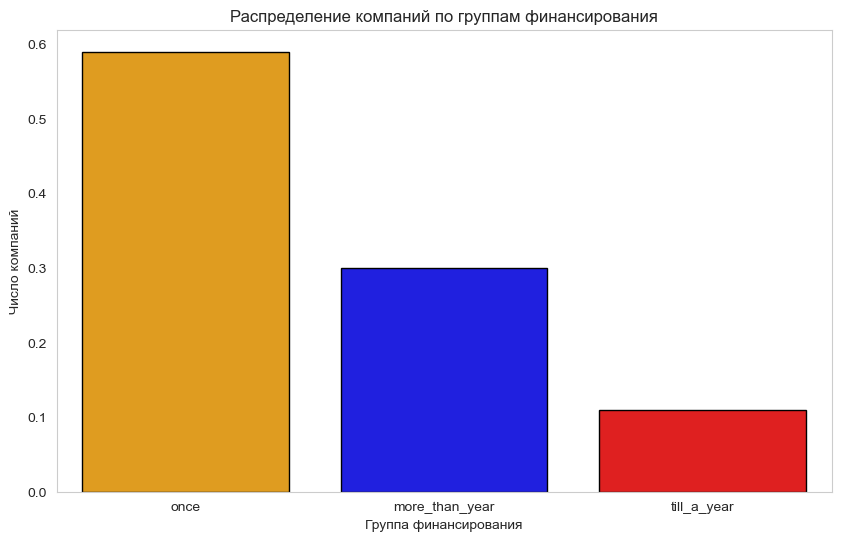

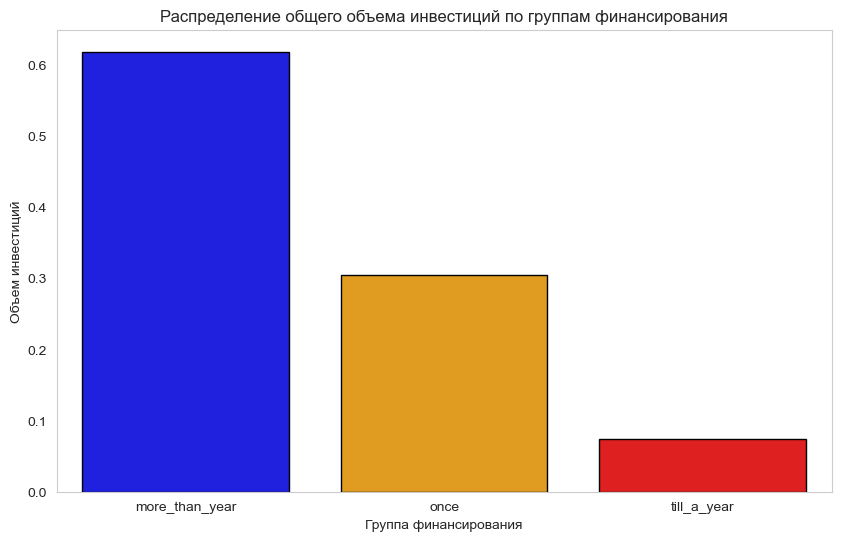

In [27]:
# Напишем функцию, которая будет создавать столбчатую диаграмму в зависимости от заданных параметров
def plot_func(df, column, value, title, xlabel, ylabel, agg_f):
    grouped = df.groupby(column)[value].agg(agg_f)
    grouped_normalized = grouped / grouped.sum()
    sorted_groups = grouped_normalized.sort_values(ascending=False).reset_index()
    
    plt.figure(figsize=(10,6))
    sns.barplot(
        data=sorted_groups,
        x=column,
        y=value,
        palette={'once': 'orange', 'more_than_year': 'blue', 'till_a_year': 'red'},
        edgecolor='black'
    )
    
    plt.title(f'Распределение {title}')
    plt.xlabel(f'{xlabel}')
    plt.ylabel(f'{ylabel}')
    plt.grid(axis='y')
    plt.show()

# Вызовем функцию для подсчета числа компаний по группам финансирования
plot_func(df, column = 'funding_group', value = 'name', title = 'компаний по группам финансирования', xlabel = 'Группа финансирования', ylabel = 'Число компаний', agg_f = 'count')
# Вызовем функцию для подсчета общего объема инвестиций по группам финансирования
plot_func(df, column = 'funding_group', value = 'funding_total_usd', title = 'общего объема инвестиций по группам финансирования', xlabel = 'Группа финансирования', ylabel = 'Объем инвестиций', agg_f = 'sum')


По **количеству компаний** лидирует группа с **единичным** раундом финансирования - примерно **60%**, за ней идет группа с финансированием **больше года** - около **30%**, меньше всего - около **10%** - группа с финансированием **до года**.

По **объему инвестиций** распределение иное:
- более **60%** - группа с финансированием **больше года**;
- около **30%** - группа с **разовым** финансированием;
- менее **10%** - группа с финансированием **до года**.

Достаточно ожидаемо, что по объему инвестиций лидирует именно группа дольше всего получающая финансирование.

### 2.2 Выделение средних и нишевых сегментов рынка

Компании указывают свой сегмент рынка в столбце `market`. Рассчитаем, как часто в датасете встречается каждый из сегментов. Сегменты, к которым относится более 120 компаний, отнесем к массовым, сегменты, в которые входит от 35 до 120 включительно, отнесем к средним, а сегменты до 35 компаний отнесем к нишевым. Рассчитаем, сколько сегментов попадает в каждую из категорий.

Построем график распределения количества компаний в сегментах и отобразим на нём разделение на нишевые и средние сегменты.

In [28]:
# Рассчитываем частоту каждого сегмента
# Уберем из промежуточных данных сегмент `unknown`, т.к. это не однородный сегмент, а заглушка
market_counts = df['market'].value_counts().reset_index()
market_counts.columns = ['market', 'count']
market_counts = market_counts[market_counts['market'] != 'unknown']
market_counts

,market,count
0,software,4812
1,biotechnology,3589
3,mobile,2343
4,ecommerce,1866
5,curatedweb,1692
...,...,...
390,flashstorage,1
391,projectmanagement,1
392,portals,1
393,serviceindustries,1


In [29]:
# Категоризируем сегменты по количеству компаний
bins = [0, 35, 120, float('inf')]
labels = ['niche', 'mid', 'mass']
market_counts['category'] = pd.cut(market_counts['count'], bins=bins, labels=labels)
pd.cut(market_counts['count'], bins=bins, labels=labels).value_counts()

count
niche    289
mid       57
mass      48
Name: count, dtype: int64

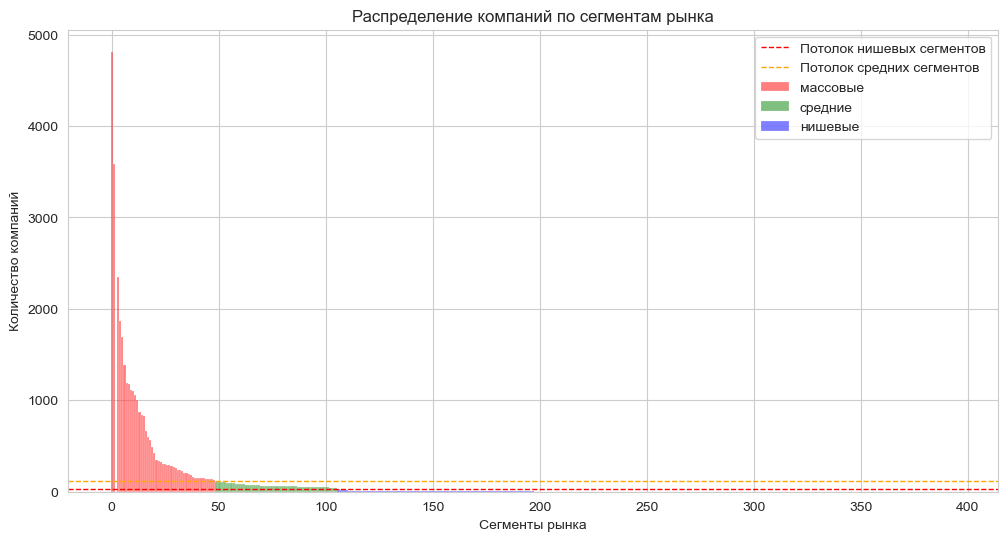

In [30]:
# Построим гистограмму с отображением категории сегментов
plt.figure(figsize=(12, 6))
sns.histplot(
    data=market_counts,
    x=market_counts.index,
    weights='count',
    hue='category',
    palette={'niche': 'blue', 'mid': 'green', 'mass': 'red'},
    discrete=True,
    hue_order=['niche', 'mid', 'mass']
)
nich = 34
mid= 120
plt.axhline(nich, color='red',
                linestyle='--', linewidth=1,)
plt.axhline(mid, color='orange',
                linestyle='--', linewidth=1,)

plt.xlabel('Сегменты рынка')
plt.ylabel('Количество компаний')
plt.title('Распределение компаний по сегментам рынка')
plt.legend(labels=['Потолок нишевых сегментов','Потолок средних сегментов','массовые', 'средние', 'нишевые'],
           loc='upper right')
plt.show()

Из примерно **400** сегментов рынка только по около **50** сегментов рынка являются соответственно **средними** или **массовыми**. В совокупности ненишевые сегменты составляют около одной четвертой всех сегментов. С другой стороны, они включают основную часть компаний.

Оставим в столбце `market` только массовые сегменты. Для остальных сегментов заменим значения на заглушки — `niche` для нишевых и `mid` для средних.


In [31]:
# Создадим списки столбцов по категориям
mid_list = market_counts[market_counts['category'] == 'mid']['market'].tolist()
niche_list = market_counts[market_counts['category'] == 'niche']['market'].tolist()

In [32]:
# Заменим нишевые и средние сегменты
df.loc[df['market'].isin(mid_list), 'market'] = 'mid'
df.loc[df['market'].isin(niche_list), 'market'] = 'niche'

## Шаг 3. Работа с выбросами и анализ

### 3.1. Анализируем и помечаем выбросы в каждом из сегментов
По предобработанному столбцу `funding_total_usd` графическим образом оценим, какой размер общего финансирования для одной компании будет типичным, а какой — выбивающимся. Укажим интервал, в котором лежат типичные значения.

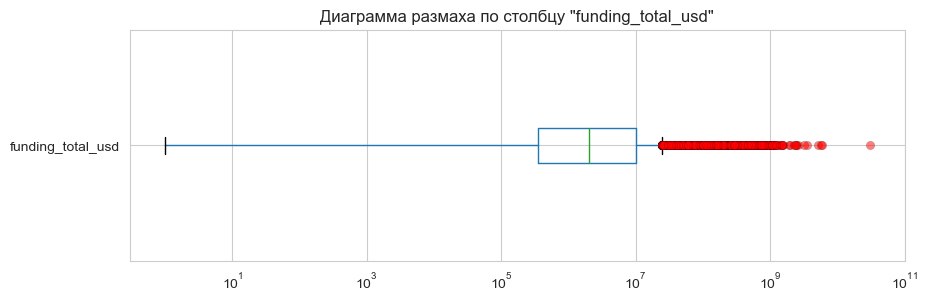

In [33]:
# Построим диаграмму размаха по столбцу 'funding_total_usd'
df.boxplot(column='funding_total_usd', figsize=(10,3), vert=False, flierprops=dict(markerfacecolor='red', markersize=6, marker='o', alpha=0.5, markeredgewidth=0.2))
plt.title('Диаграмма размаха по столбцу "funding_total_usd"')
plt.xscale('log')
plt.show()

In [34]:
# Посчитаем типичные значения и выбросы с помощью IQR
Q1 = df['funding_total_usd'].quantile(0.25)
Q3 = df['funding_total_usd'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR
down_bound = (df['funding_total_usd'] < 0).sum()
print(f'Типичнные значения лежат в интервале от {Q1} до {Q3} $')
print(f'Статистические выбросы лежат выше {upper_bound} $')
print(f'Количество значений ниже 0: {down_bound}')

Типичнные значения лежат в интервале от 350000.0 до 10000000.0 $
Статистические выбросы лежат выше 24475000.0 $
Количество значений ниже 0: 0


Определим компании с аномальным объёмом общего финансирования — используем метод IQR отдельно по каждому сегменту.

Определим сегменты рынка с наибольшей долей компаний, получивших аномальное финансирование, и выведим топ таких сегментов.

In [35]:
# Найдем выбросы в разрезе каждого сегмента и сохраним информацию о них в df_outliers
df_outliers = pd.DataFrame()
for market in df['market'].unique():
    Q1 = df[df['market'] == market]['funding_total_usd'].quantile(0.25)
    Q3 = df[df['market'] == market]['funding_total_usd'].quantile(0.75)
    IQR = Q3 - Q1
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df['funding_total_usd'] > upper_bound) & (df['market'] == market)][['name', 'market']]
    df_outliers = pd.concat([df_outliers, outliers], ignore_index=True)

df_outliers['market'].value_counts().sort_index()

market
advertising           136
analytics              82
apps                   32
automotive             22
bigdata                23
biotechnology         382
cleantechnology       151
cloudcomputing         25
consulting             58
curatedweb            202
design                 15
ecommerce             269
education             112
enterprisesoftware    146
entertainment          25
fashion                40
finance               104
games                 117
hardwaresoftware      123
healthandwellness     113
healthcare            128
hospitality            44
internet               37
manufacturing          63
marketplaces           30
medical                21
messaging              38
mid                   556
mobile                309
music                  33
networking             22
news                   40
niche                 132
nonprofits             13
photography            33
publicrelations        16
realestate             48
saas                   44
searc

In [36]:
# Узнаем полные размеры сегментов, в которых были зафиксированы аномалии
df_market_counts = df['market'].value_counts()[df_outliers['market'].unique()].sort_index()
# Используем распределение аномальных компаний по сегментам
out_market_counts = df_outliers['market'].value_counts().sort_index()
# Найдем отношение количества аномалий в сегменте к полным размерам сегментов
group_normalized = round(out_market_counts/df_market_counts * 100,1)
# Сделаем топ-10 сегментов по удельному весу аномалий в них
print('Топ-10 сегментов по доле компаний с аномалиями')
print(group_normalized.sort_values(ascending=False).head(10))

Топ-10 сегментов по доле компаний с аномалиями
market
realestate        17.2
entertainment     16.7
consulting        16.6
search            16.5
cloudcomputing    16.4
photography       16.2
saas              16.2
video             16.0
technology        16.0
niche             15.9
Name: count, dtype: float64


Вывод:
По аномалиям **лидируют** традиционные и сервисные отрасли, такие как недвижимость `realestate`, консалтинг `consulting`, развлечения `entertainment`, а также технологические сегменты — облачные вычисления `cloudcomputing`, `SaaS`, поисковые технологии `search` и видео `video`.
Наличие аномалий может быть связано с **высокой конкуренцией** в сервисных отраслях и необходимостью **значительных инвестиций** в технологические и инновационные сегменты.

Сегмент niche объединяет малые группы компаний, что может объяснять его попадание в топ за счёт **специфики** и меньшей статистической **устойчивости**.

### 3.2 Определяем границы рассматриваемого периода, отбрасываем аномалии

Проверим по датасету, можно ли считать, что нам предоставили полные данные за 2014 год. Затем исключим из датасета компании, которые мы ранее посчитали получившими аномальное финансирование.

Когда исключим аномальные записи, на основе столбцов `mid_funding_at` и `funding_rounds` оставим в датасете данные только об определённых компаниях. Такие компании должны были получать финансирование в годы, когда было зафиксировано 50 или более раундов финансирования.

In [37]:
# Посмотрим распределение данных в столбцах с датой
start_date = pd.to_datetime('2014-01-01')
end_date = pd.to_datetime('2014-12-31')
for column in ['founded_at','first_funding_at','last_funding_at']:
    print(df[df[column].between(start_date, end_date)][column].sort_values())

37085   2014-01-01
37387   2014-01-01
37386   2014-01-01
37384   2014-01-01
37381   2014-01-01
           ...    
38547   2014-11-05
38549   2014-11-19
38551   2014-11-26
38552   2014-12-01
38553   2014-12-13
Name: founded_at, Length: 1015, dtype: datetime64[ns]
17899   2014-01-01
37172   2014-01-01
47172   2014-01-01
47175   2014-01-01
37171   2014-01-01
           ...    
30009   2014-12-02
30010   2014-12-02
37512   2014-12-02
38413   2014-12-24
49437   2014-12-31
Name: first_funding_at, Length: 6476, dtype: datetime64[ns]
26805   2014-01-01
25924   2014-01-01
14173   2014-01-01
44065   2014-01-01
25546   2014-01-01
           ...    
46073   2014-12-02
14858   2014-12-02
17006   2014-12-02
38413   2014-12-24
49437   2014-12-31
Name: last_funding_at, Length: 11913, dtype: datetime64[ns]


Данные представлены за весь 2024 год.

In [38]:
# Оставляем только те строки, где 'name' не входит в df_outliers['name']
df = df[~df['name'].isin(df_outliers['name'])]

In [39]:
# Находим года, где было от 50 раундов финансирования
df['mid_funding_year'] = df['mid_funding_at'].dt.year
grouped = df.groupby('mid_funding_year')['funding_rounds'].sum()
grouped = grouped[grouped >= 50]
grouped = grouped.reset_index().sort_values(by='mid_funding_year')
# Оставляем только те компании, где был раунд финансирования в год с более чем 50 совокупными раундами финансирования
df = df[df['mid_funding_year'].isin(grouped['mid_funding_year'])]
# Выводим список лет
selected_years = grouped['mid_funding_year'].tolist()
print(f"Рассматриваем данные только по следующим годам: {selected_years}")

Рассматриваем данные только по следующим годам: [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014]


### 3.3. Анализ типов финансирования по объёму и популярности

Построим график, который покажет, какие типы финансирования в сумме привлекли больше всего денег.

Также построим график, который покажет популярность разных типов финансирования — какие типы финансирования чаще всего используются компаниями.

Сравним графики и выделим часто используемые типы финансирования, которые при этом характеризуются небольшими объёмами, и наоборот.

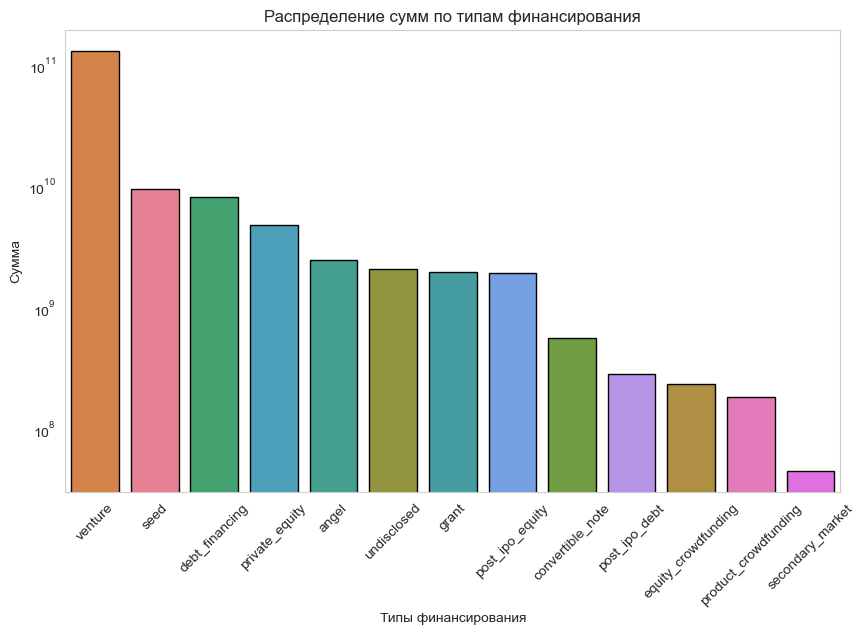

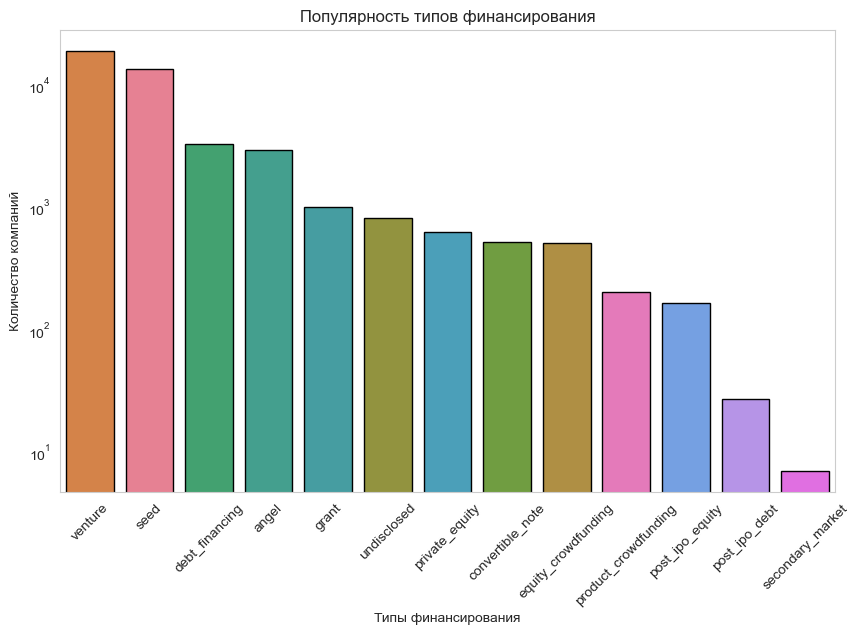

In [40]:
# Создадим список анализируемых столбцов
type_fin_list = ['seed','venture','equity_crowdfunding','undisclosed','convertible_note','debt_financing','angel','grant','private_equity','post_ipo_equity','post_ipo_debt','secondary_market','product_crowdfunding']

# Создаем палитру в виде словаря
palette_dict = {col: sns.color_palette("husl", len(type_fin_list))[i] for i, col in enumerate(type_fin_list)}

# График сумм финансирования с log шкалой
plt.figure(figsize=(10, 6))
grouped_sum = df[type_fin_list].sum().sort_values(ascending=False)
sns.barplot(
    x=grouped_sum.index,
    y=grouped_sum.values,
    palette=palette_dict,
    edgecolor='black'
)
plt.title('Распределение сумм по типам финансирования')
plt.xlabel('Типы финансирования')
plt.ylabel('Сумма')
plt.yscale('log')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

# График популярности с log шкалой
plt.figure(figsize=(10, 6))
grouped_count = (df[type_fin_list] > 0).sum().sort_values(ascending=False)
sns.barplot(
    x=grouped_count.index,
    y=grouped_count.values,
    palette=palette_dict,
    edgecolor='black'
)
plt.title('Популярность типов финансирования')
plt.xlabel('Типы финансирования')
plt.ylabel('Количество компаний')
plt.yscale('log')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


В целом результаты обоих графиков согласуются. Наблюдается **положительная связь** между популярностью и объемами финансирования. Можно обратить внимание на `post_ipo_equity` с низкой популярностью, но средним объемом финансирования или `private_equity` со средней популярностью, но достаточно высоким объемом финансирования в рамках распределения данных на логарифмической шкале, или `grant` с обратной ситуацией.

Важно понимать, что, по сути, у нас наблюдаются явные лидеры одновременно по популярности и по суммам финансирования. Большинство других столбцов **по сравнению с лидерами незначительны**, что осложняет анализ.

Построим график суммарных объёмов возвратов от разных типов финансирования за весь период на основе дополнительного датасета.

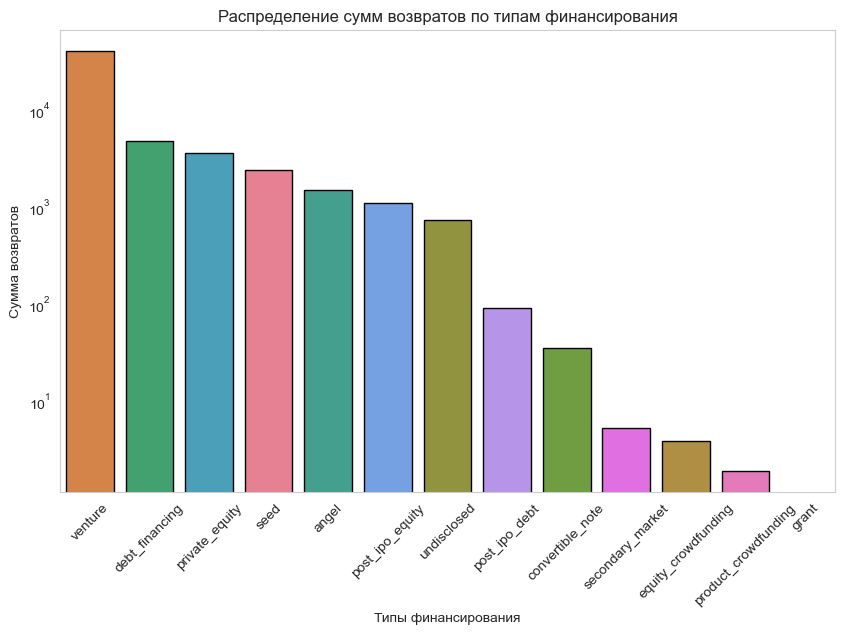

In [41]:
# График сумм возврата финансирования с log шкалой
plt.figure(figsize=(10, 6))
grouped_sum = df_ad[type_fin_list].sum().sort_values(ascending=False)
sns.barplot(
    x=grouped_sum.index,
    y=grouped_sum.values,
    palette=palette_dict,
    edgecolor='black'
)
plt.title('Распределение сумм возвратов по типам финансирования')
plt.xlabel('Типы финансирования')
plt.ylabel('Сумма возвратов')
plt.yscale('log')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

Распределение возвратов ожидаемо в целом **коррелирует** с распределением сумм по типам финансирования. Распределения похожи, однако возвраты по **грантам** отсутствуют полностью, что, вероятно, говорит об их безвозмедности.

## Шаг 4. Анализ динамики

### 4.1 Динамика предоставления финансирования по годам

Используя столбцы `funding_total_usd` и `funding_rounds`, рассчитаем для каждой компании средний объём одного раунда финансирования.

На основе получившейся таблицы построим графики, отражающие:
* динамику типичного размера средств, которые стартапы получали в рамках одного раунда финансирования;

* динамику общего количества раундов за каждый год.

In [42]:
# Делаем временный датафрейм и создаем таблицу с нужными данными
temp_df = df
temp_df['av_round_fin'] = df['funding_total_usd'] / df['funding_rounds']
av_fin = temp_df[['name','av_round_fin','mid_funding_year', 'funding_rounds']]

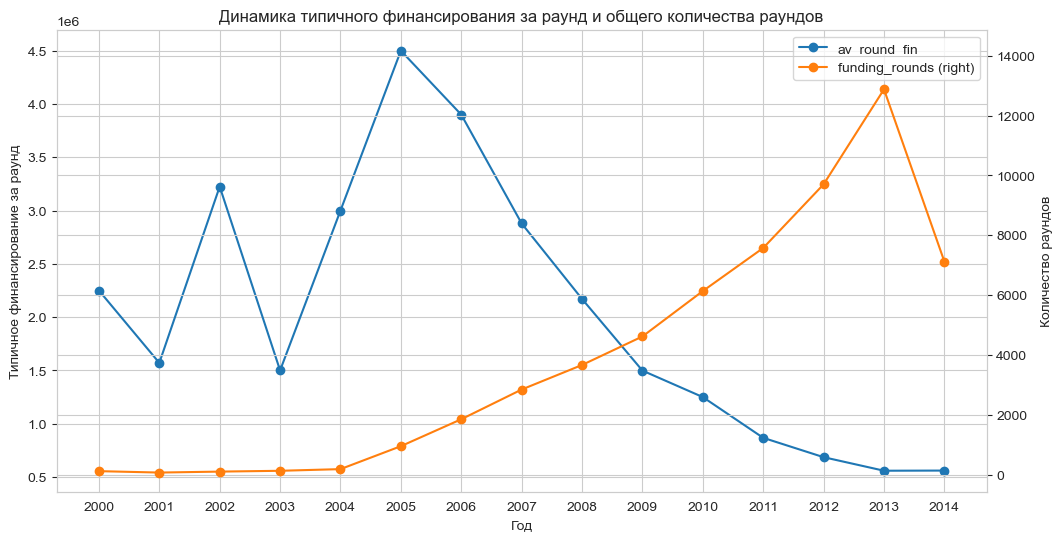

In [43]:
# Строим линейный график, где отображаются одновременно типичный размер средств и количество раундов
grouped = av_fin.groupby('mid_funding_year').agg({'av_round_fin': 'median', 'funding_rounds': 'sum'})
grouped.plot.line(
    figsize=(12, 6),
    marker='o',
    secondary_y='funding_rounds',
    ylabel='Количество раундов',
    title = 'Динамика типичного финансирования за раунд и общего количества раундов').set(
    ylabel='Типичное финансирование за раунд',
    xlabel='Год')

plt.grid(axis='y')
plt.xticks(grouped.index)
plt.ylim(top=plt.ylim()[1] * 1.1)
plt.show()

Мы видим устойчивую динамику на **рост** количества раундов до 2014 года. Динамика типичного размера финансирования была **неустойчива** до 2005 года. С 2006 года начинается устойчивое падение.
Максимальный типичный размер средств за раунд был **в 2005** году. В 2014 году произошло **резкое падение** количества раундов.

### 4.2 Динамика размера общего финансирования по массовым сегментам рынка для растущих в 2014 году сегментов

Составим сводную таблицу, в которой указывается суммарный размер общего финансирования `funding_total_usd` по годам и сегментам рынка. Отберем из неё только те сегменты, которые показывали рост размера суммарного финансирования в 2014 году по сравнению с 2013.

На графике отразим, как менялся суммарный размер общего финансирования в каждом из отобранных сегментов по годам, за которые у нас достаточно данных. Рассмотрим только массовые сегменты.

In [44]:
# Создаем сводную таблицу
pivot_fund = df.pivot_table(index='mid_funding_year', columns='market', values='funding_total_usd', aggfunc='sum')
# Фильтруем данные по условию
result = pivot_fund.loc[:, pivot_fund.loc[2014] > pivot_fund.loc[2013]]
result

market,apps,bigdata,design,internet,manufacturing,medical,mid,niche,realestate,saas,startups,technology,unknown
mid_funding_year,,,,,,,,,,,,,
2000,NaN,NaN,NaN,10000000.0,56659310.0,24000000.0,8.244039e+07,14600000.0,2500000.0,NaN,NaN,NaN,1839560.0
2001,NaN,NaN,NaN,NaN,2368582.0,NaN,9.441026e+06,24020000.0,NaN,NaN,NaN,22160000.0,10160345.0
2002,NaN,NaN,NaN,1100000.0,NaN,NaN,1.888580e+07,NaN,5275000.0,2000000.0,NaN,11000000.0,242132.0
2003,NaN,NaN,NaN,NaN,4269608.0,NaN,4.323840e+07,NaN,6292200.0,NaN,NaN,NaN,4155202.0
2004,NaN,NaN,NaN,10500000.0,3000000.0,NaN,5.443816e+07,NaN,NaN,NaN,NaN,1750000.0,10847977.0
2005,NaN,NaN,9300000.0,1775000.0,61770000.0,11090000.0,2.144075e+08,NaN,250000.0,5240000.0,NaN,50728425.0,28384331.0
2006,1310600.0,NaN,707000.0,5000.0,163957751.0,20250000.0,3.475226e+08,11180000.0,2080000.0,4791121.0,NaN,22791000.0,46049840.0
2007,NaN,7780000.0,10800000.0,4495379.0,147726051.0,2100000.0,5.035429e+08,44494637.0,33220000.0,14652595.0,NaN,180190209.0,35532468.0
2008,4300000.0,2452515.0,5944302.0,23412964.0,173054260.0,28812744.0,5.503748e+08,22279331.0,46613100.0,27226900.0,5010387.0,277726238.0,45345010.0


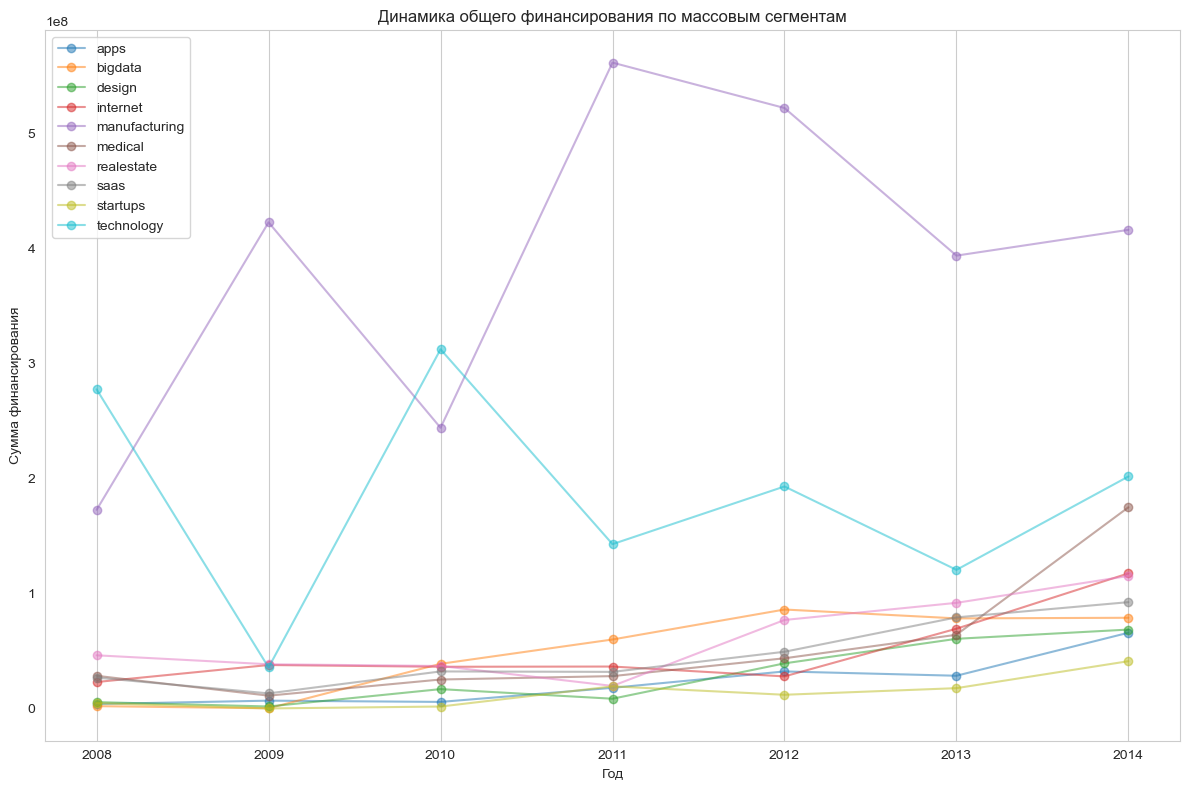

In [45]:
# Строим линейный график с динамикой общего финансирования по годам
# Убираем лишние столбцы и годы, в которых есть пропуски
filtered = result.drop(['mid','niche','unknown'], axis=1)
filtered = filtered[filtered.index >= 2008]
filtered.plot.line(
    figsize=(12, 8),
    marker='o',
    ylabel= 'Сумма финансирования',
    title = 'Динамика общего финансирования по массовым сегментам',
    xlabel= 'Год',
    alpha = 0.5)

plt.grid(axis='y')
plt.tight_layout()
plt.legend(loc='upper left')
plt.show()

При условии оценивания динамика с 2008 года, самые быстрорастущие сегменты это `manufacturing` и облачные продукты `saas`. `Technology` показывает высокий результат, но по сравнению с 2008 годом роста не произошло.

### 4.3 Годовая динамика доли возвращённых средств по типам финансирования

Для каждого года и каждого вида финансирования рассчитаем нормированные значения возврата средств.

In [46]:
# Создадим таблицу, где отражается доля возврата для каждого года и типа финансирования
ret_table = ((df_ad*1000000)/(df.groupby('mid_funding_year')[type_fin_list].sum() + 1e-60)) * 100
# Уберем аномальные значения
ret_table = ret_table.mask((ret_table > 500))
ret_table

,seed,venture,equity_crowdfunding,undisclosed,convertible_note,debt_financing,angel,grant,private_equity,post_ipo_equity,post_ipo_debt,secondary_market,product_crowdfunding
year,,,,,,,,,,,,,
2000,99.647118,16.892193,0.000000,69.704242,0.000000,61.857143,26.695637,0.0,0.000000,27.106937,0.000000,2.591054,0.000000
2001,107.959178,10.799051,0.000000,58.748332,0.666667,77.025782,118.000000,0.0,0.000000,NaN,0.000000,NaN,0.000000
2002,62.970655,68.228180,0.000000,60.887827,NaN,22.338821,113.666667,0.0,20.133333,113.333333,0.000000,NaN,0.000000
2003,50.527619,62.826000,0.000000,91.439689,NaN,103.809524,60.572031,0.0,NaN,NaN,0.000000,NaN,0.000000
2004,54.847551,83.700914,0.000000,52.755930,NaN,43.969776,83.350426,0.0,NaN,NaN,0.000000,NaN,0.000000
2005,67.469541,54.658588,0.000000,107.199235,NaN,34.496435,50.989400,0.0,48.000000,73.185653,0.000000,NaN,0.000000
2006,92.537180,34.367765,20.363172,75.943816,16.631807,80.377203,67.485297,0.0,93.545296,NaN,0.000000,NaN,0.000000
2007,36.615335,29.724281,NaN,50.497081,22.809721,60.248808,81.783745,0.0,57.905632,203.000000,0.000000,NaN,0.000000
2008,29.708312,19.087260,NaN,34.206041,5.978832,92.748376,41.247557,0.0,67.992540,234.111111,0.000000,NaN,0.000000


Построим график, на котором отобразим нормированные значения возврата средств для типов финансирования `venture`, `debt_financing`, `private_equity`, `seed` и `angel`.

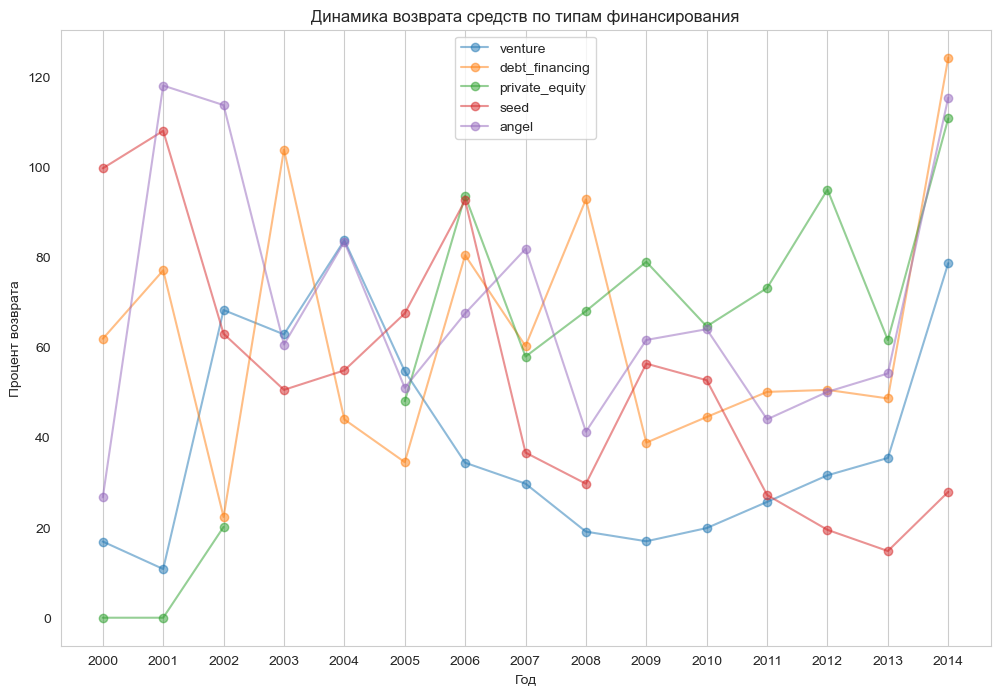

In [47]:
# Построим линейный график с динамикой процента возврата средств по определенным типам финансирования
ret_table= ret_table[['venture','debt_financing','private_equity','seed','angel']]
ret_table.plot.line(
    figsize=(12, 8),
    marker='o',
    ylabel= 'Процент возврата',
    title = 'Динамика возврата средств по типам финансирования',
    xlabel= 'Год',
    alpha = 0.5,
)


plt.grid(axis='y')
plt.legend(loc='upper center')
plt.xticks(ret_table.index)
plt.show()

Динамика возвратов по типам финансирования волатильна. Достаточно устойчивый рост с **2009** года показывают `debt_financing` и `venture`, менее устойчивый  - `private_equity`. У `angel` тенденция роста сильно менее устойчива. Также все типы финансирования получили резкое увеличение процента возврата в 2014 году.


## Шаг 5. Итоговый вывод и рекомендации

В проекте были выполнены следующие шаги:
1. **Знакомство с данными и их предобработка**, в том числе:
- **обработка** названий столбцов, пропусков и дубликатов;
- **удаление** информации, которая могла бы помешать анализу;
2. Компании были разделены на различные **группы финансирования**. **Количественно** превалируют компании с одним раундом финансирования, а по **объему инвестиций** группа дольше всех получающая финансирование.
3. **Сегменты** рынка были **разделены** на массовые, средние и нишевые. В совокупности **ненишевые** сегменты составляют около одной четвертой всех сегментов.
4. Были проанализированы аномалии в общем объеме привлеченных средств. По аномалиям лидируют традиционные и сервисные отрасли, а также технологические сегменты. Наличие аномалий в них может быть связано с высокой **конкуренцией** и (или) необходимостью **значительных** инвестиций.
5. Мы **исключили** аномалии, а также оставили информацию только о тех компаниях, которые получали финансирование в годы, когда было зафиксировано **50** или более раундов финансирования.
6. Мы проанализировали объемы финансирования, популярность и объем возвратов различных типов финансирования.
- В целом результаты **согласуются**. Наблюдается положительная связь между популярностью и объемами финансирования. У отдельных сегментов, таких как: финансирование **после IPO**, инвестиции в виде **прямых вложений** и **гранты** популярность и объемы финансирование не вполне согласуются. Распределение возвратов в целом **коррелирует** с распределением сумм по типам финансирования кроме грантов, которые, вероятно, безвозмездны.
7. Была проанализирована динамика **количества раундов** и **типичного размера** финансирования. Наблюдается устойчивая динамика роста количества раундов до 2014 года, после чего происходит **резкое падение**. С 2006 года начинается устойчивое падение типичного размера финансирования. Возможно это говорит о желании уменьшить риски со стороны инвесторов. **Максимальный** типичный размер средств за раунд был в **2005** году.
8. Динамика общего финансирования по массовым сегментам показала, что самые быстрорастущие сегменты это **производственный сектор** и **программное обеспечение как услуга** (`SaaS`).
9. Достаточно устойчивый рост процента возврата финансирования с **2009** года показывают **долговое** и **венчурное финансирование**, менее устойчивый - **прямые инвестиции**. Все типы финансирования получили резкое увеличение процента возврата в 2014 году.

В целом выводы **согласуются** между собой.

Рекомендации заказчику:

Стоит обратить внимание на массовые сегменты в виде **производственного** сектора и **программного обеспечения** как услуги (`SaaS`) из-за их темпов роста. Дополнительно программное обеспечение имеет **высокий** потенциал масштабирования. Особенно высокие объемы финансирования технологических отраслей могут быть связаны с их **популярностью** у инвесторов.
Наиболее уместными будут **долговое и венчурное** инвестирование из-за устойчивого роста процента возврата финансирования. Венчурное инвестирование будет более оптимальным для **инновационных** секторов как программное обеспечение, а долговое финансирование - для **производственного** сектора.
